## Importando los datos

In [14]:
import matplotlib.pylab as plt

#para no tener que poner plt.show cada vez
%matplotlib inline

In [1]:
''' Definimos la funcion para leer el archivo geneX '''
import re
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line = re.sub('["\n]', '', line)
        col=line.split(',')
        data.append(col)
    return data

Al cargar los datos, la variable geneX tendra en su prmer fila (geneX[0]) los datos de los diferenctes momentos a los cuales se tomo la muestra. Luego en la filas subsiguientes (geneX[n]), el primer elemento corresponde al nombre del gen y los demas a los valores de expresion de dicho gen a cada tiempo.

In [2]:
geneX=ldata('geneX.csv')
geneX[2]

['AT1G01120',
 '6.71990716589494',
 '4.59135741517451',
 '3.40701378041858',
 '5.91999209688856',
 '5.58896169640829',
 '5.94697471723513',
 '5.52492906279461',
 '4.14434931557895',
 '3.85372442148385',
 '6.5603050343132',
 '4.98680367516588',
 '5.70994059991009']

Asignamos los nombres a una lista y los valores a una matriz de numpy, donde las filas corresponden a cada gen y las columnas a cada tiempo.

In [3]:
import numpy as np
valores_genes=np.zeros((500, 12))
nombre_genes=[]
for j in range(1,501):
    nombre_genes.append(geneX[j][0])
    for i in range(1,13):
        valores_genes[j-1,i-1]=float(geneX[j][i])

## Defininendo funciones

Definimos funciones para calcular infomap y para calcular la modularidad. Para poder calcular comunidades con el metodo infomap, deberan instalar el paqute de igraph para python. Para hacerlo deben abrir una terminal y escribir 'pip3 install --user python-igraph'.

In [76]:
import igraph as igraph
import networkx as nx

def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [71]:
import pandas as pd
gx = pd.read_csv('geneX.csv', index_col=0)
G = nx.from_pandas_adjacency(gx.T.corr()>0.95)

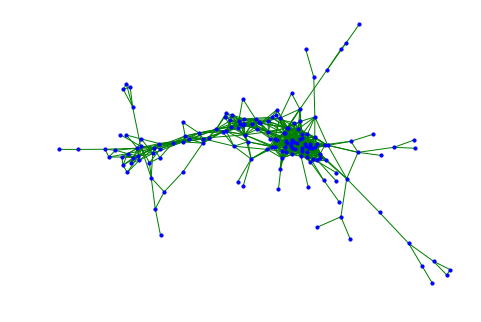

In [20]:
nx.draw(max(nx.connected_component_subgraphs(G),key=len), node_size=10, edge_color="green", node_color="blue")

In [72]:
labels = clusterize(G, "infomap")

(array([121.,   1.,  99.,  67.,  18.,   4.,  10.,   1.,   1.,   1.,   1.,
          1.,   9.,   1.,   4.,   1.,   3.,   1.,   2.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   3.,   1.,   5.,   4.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   3.,   2.,   1.,   1.,
          1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,
          1.,   2.,   1.,   1.,   1.,   1.,   2.,   1.,   5.,   1.,   2.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   5.,   2.,   1.,
          1.,   1.,   2.,   1.,   2.,   1.,   6.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   2.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   2.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
    

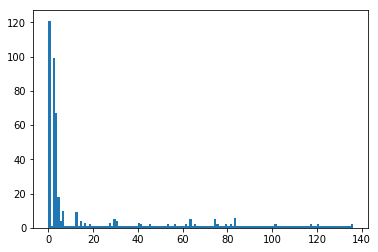

In [73]:
plt.hist(lables.values(), bins=max(lables.values()))

In [154]:
import igraph as igraph
import networkx as nx
import time

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']


class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm



Probamos la funcion modularity

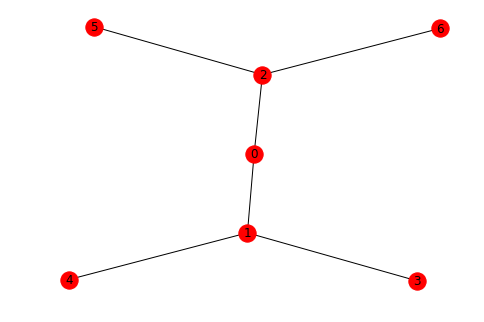

In [128]:
import matplotlib.pyplot as plt
G = nx.balanced_tree(h=2,r=2)
nx.draw(G,with_labels=True)
plt.show()

In [129]:
modularity(G,[[0,1,3,4],[5,2,6]])

0.3194444444444444

In [130]:
modularity(G,[[1,2],[0,4,5,6,3]])

-0.4999999999999996

Algunos paquetes que les pueden serivr para hacer el dendograma: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [ ]:
# For dendogram
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist